<a href="https://colab.research.google.com/github/kiru21125/GithubPractice/blob/main/BirdsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'birds-vs-drone-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1858955%2F3035286%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240312%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240312T062920Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6d1a96746fb9ea23435fec66431eb53f41fab038c6e9790485071c1b8c48d33049f7545d1fb5f84463e456e70102382b2d8e842a06d54afc77d22ffd3c955d7ee2f265beb523c567f054c3d6024158d5798a522086c0b7bea2358acbfff03db51145b31a20447acaf46cc3e9d8d77e1f4f7d21ba0b01b2279769351cfbee76cec0f7afeeba79dbfa1262792d03b153428338acf901537905e974e0c3cc2925dee1ba11c534350bf9d08634750949f73ef4e27646b268862eb4ab385d4af15ca83272f690478ecb2d8fa4d4dc1de57775093291b1f4a205d9295040cfb458b86f066964b67000f18e0f7e6000bbda859e9a07b804cb81cdbdcb87ce2a01a5ccc3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 81846969 bytes downloaded
Downloaded and uncompressed: birds-vs-drone-dataset
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# AUGMENTATION

In [ ]:
# Assuming you have the original dataset loaded and separated into "birds" and "drones" directories
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from keras.preprocessing.image import ImageDataGenerator,  save_img

# Create an ImageDataGenerator with specified augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Directory to save the augmented images
augmented_dir = '/kaggle/working/augmented_data'

# Create directories to store augmented data
os.makedirs(os.path.join(augmented_dir, 'Birds'), exist_ok=True)
os.makedirs(os.path.join(augmented_dir, 'Drones'), exist_ok=True)


**Bird Images Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import os

# ...

# Augment the "birds" class
for image_file in os.listdir('/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Birds'):
    img = load_img(os.path.join('/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Birds', image_file), target_size=(128, 128))
    img = img_to_array(img)
    img = img.reshape((1,) + img.shape)

    i = 0
    for batch in datagen.flow(img, batch_size=1):
        img = Image.fromarray(batch[0].astype('uint8'))
        img.save(os.path.join(augmented_dir, 'Birds', f'augmented_bird_{i}.jpg'))
        i += 1
        if i >= 400:  # Adjust the number of augmentations as needed
            break


**Drone Images Augmentation**

In [ ]:
# Augment the "drones" class
for image_file in os.listdir('/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Drones'):
    img = load_img(os.path.join('/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Drones', image_file), target_size=(128, 128))
    img = img_to_array(img)
    img = img.reshape((1,) + img.shape)

    i = 0
    for batch in datagen.flow(img, batch_size=1):
        img = Image.fromarray(batch[0].astype('uint8'))
        img.save(os.path.join(augmented_dir, 'Drones', f'augmented_drone_{i}.jpg'))
        i += 1
        if i >= 400:  # Adjust the number of augmentations as needed
            break


# Copying Files

In [ ]:
import os
import shutil

# Define the source directory in Kaggle's input directory
source_dir = '/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Birds'  # Replace with the actual source directory

# Define the destination directory in the working directory
destination_dir = '/kaggle/working/augmented_data/Birds'  # Replace with the desired destination directory

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List the files in the source directory
file_list = os.listdir(source_dir)

# Define the number of images to copy and move (e.g., 400)
num_images_to_copy = 400

# Copy and move the specified number of images
for i, file_name in enumerate(file_list):
    if i >= num_images_to_copy:
        break
    source_file_path = os.path.join(source_dir, file_name)
    destination_file_path = os.path.join(destination_dir, file_name)

    # Copy the file to the destination directory
    shutil.copy(source_file_path, destination_file_path)
    # print(f'Copied: {file_name}')

print(f'Copied {num_images_to_copy} images from {source_dir} to {destination_dir}')


Copied 400 images from /kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Birds to /kaggle/working/augmented_data/Birds


In [ ]:
import os
import shutil

# Define the source directory in Kaggle's input directory
source_dir = '/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Drones'  # Replace with the actual source directory

# Define the destination directory in the working directory
destination_dir = '/kaggle/working/augmented_data/Drones'  # Replace with the desired destination directory

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List the files in the source directory
file_list = os.listdir(source_dir)

# Define the number of images to copy and move (e.g., 400)
num_images_to_copy = 400

# Copy and move the specified number of images
for i, file_name in enumerate(file_list):
    if i >= num_images_to_copy:
        break
    source_file_path = os.path.join(source_dir, file_name)
    destination_file_path = os.path.join(destination_dir, file_name)

    # Copy the file to the destination directory
    shutil.copy(source_file_path, destination_file_path)
    # print(f'Copied: {file_name}')

print(f'Copied {num_images_to_copy} images from {source_dir} to {destination_dir}')


Copied 400 images from /kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Drones to /kaggle/working/augmented_data/Drones


In [ ]:
# Define the source directory where your data is located
source_directory = "/kaggle/working/augmented_data"

# Define the destination directory where the split data will be saved
destination_directory = "/kaggle/working/split_data"  # Modify to your desired destination


In [ ]:
# List of class labels
class_labels = ["Birds", "Drones"]

# Create train, validation, and test subdirectories for each class
for label in class_labels:
    os.makedirs(os.path.join(destination_directory, 'train', label), exist_ok=True)
#     os.makedirs(os.path.join(destination_directory, 'validation', label), exist_ok=True)
    os.makedirs(os.path.join(destination_directory, 'test', label), exist_ok=True)

# Split the data into training, validation, and testing sets
train_size = 0.8 # 80% for training
# validation_size = 0.3  # 20% for validation
test_size = 0.2  # 20% for testing

In [ ]:
for label in class_labels:
    source_label_dir = os.path.join(source_directory, label)
    train_label_dir = os.path.join(destination_directory, 'train', label)
#     validation_label_dir = os.path.join(destination_directory, 'validation', label)
    test_label_dir = os.path.join(destination_directory, 'test', label)

    # List all files in the source label directory
    files = os.listdir(source_label_dir)

    # Split the data into train, validation, and test sets
    train_files, test_files = train_test_split(files, test_size=0.2 , random_state=42)
    # validation_files, test_files = train_test_split(temp_files, test_size=test_size / (validation_size + test_size), random_state=42)

    # Copy the files to the corresponding directories
    for file in train_files:
        src = os.path.join(source_label_dir, file)
        dst = os.path.join(train_label_dir, file)
        shutil.copy(src, dst)

#     for file in validation_files:
#         src = os.path.join(source_label_dir, file)
#         dst = os.path.join(validation_label_dir, file)
#         shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(source_label_dir, file)
        dst = os.path.join(test_label_dir, file)
        shutil.copy(src, dst)

# First Model

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from kerastuner.tuners import RandomSearch

# Define the preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (28, 28))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

# Load and preprocess the training and testing datasets
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/split_data/train',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(28, 28)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/split_data/test',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(28, 28)
)

# Apply the preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

# Split the training dataset into training and validation sets
train_size = int(0.9 * len(train_ds))
train_images = train_ds.take(train_size)
val_images = train_ds.skip(train_size)


Found 1278 files belonging to 2 classes.


<ipython-input-13-3629c937104a>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Found 320 files belonging to 2 classes.


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(48, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 48)        153648    
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense (Dense)               (None, 64)                1228864   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1392305 (5.31 MB)
Trainable params: 1392305 (5.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming you have training and validation datasets, train the model and record the history
history = model.fit(
    train_images,  # Replace with your training data
    validation_data=val_images,  # Replace with your validation data
    epochs=10,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust batch size as needed
    verbose=2  # Set verbosity level
)

Epoch 1/10
36/36 - 21s - loss: 0.7126 - accuracy: 0.5547 - val_loss: 0.6313 - val_accuracy: 0.6270 - 21s/epoch - 592ms/step
Epoch 2/10
36/36 - 18s - loss: 0.6230 - accuracy: 0.6615 - val_loss: 0.6143 - val_accuracy: 0.5238 - 18s/epoch - 501ms/step
Epoch 3/10
36/36 - 19s - loss: 0.5563 - accuracy: 0.7370 - val_loss: 0.5070 - val_accuracy: 0.7302 - 19s/epoch - 542ms/step
Epoch 4/10
36/36 - 20s - loss: 0.3925 - accuracy: 0.8325 - val_loss: 0.3259 - val_accuracy: 0.8889 - 20s/epoch - 545ms/step
Epoch 5/10
36/36 - 17s - loss: 0.3559 - accuracy: 0.8429 - val_loss: 0.3271 - val_accuracy: 0.8730 - 17s/epoch - 476ms/step
Epoch 6/10
36/36 - 18s - loss: 0.3207 - accuracy: 0.8507 - val_loss: 0.1967 - val_accuracy: 0.9127 - 18s/epoch - 495ms/step
Epoch 7/10
36/36 - 17s - loss: 0.3002 - accuracy: 0.8750 - val_loss: 0.3306 - val_accuracy: 0.8254 - 17s/epoch - 477ms/step
Epoch 8/10
36/36 - 19s - loss: 0.2862 - accuracy: 0.8785 - val_loss: 0.3222 - val_accuracy: 0.8889 - 19s/epoch - 541ms/step
Epoch 9/

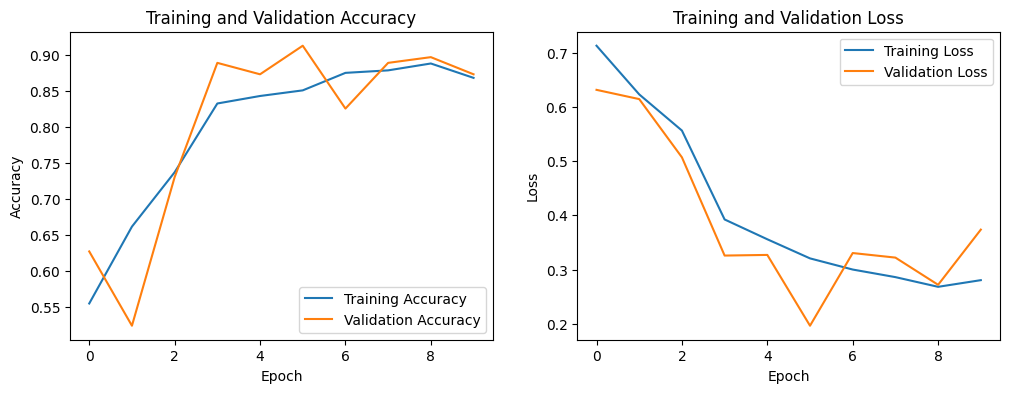

In [ ]:

# Plot training and validation accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.show()
plt.savefig('training_plots_10.png')
plt.show()
# This code will create two subplots in a single figure, one for accuracy and one for loss. It plots both training and validation accuracy as well as training and validation loss over the epochs. Adjust the number of epochs and other parameters as needed for your specific use case.

In [ ]:
# Calculate training accuracy and loss
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

40/40 [==============================] - 6s 122ms/step - loss: 0.3085 - accuracy: 0.8678
Training Loss: 0.3085
Training Accuracy: 0.8678
10/10 [==============================] - 1s 83ms/step - loss: 0.3343 - accuracy: 0.8687
Test Loss: 0.3343
Test Accuracy: 0.8687


In [ ]:
model.save('model10.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 320 files belonging to 2 classes.
1/1 [==============================] - 0s 95ms/step
Classification Report:
               precision    recall  f1-score   support

      Drones       0.76      0.62      0.68       160
       Birds       0.68      0.80      0.74       160

    accuracy                           0.71       320
   macro avg       0.72      0.71      0.71       320
weighted avg       0.72      0.71      0.71       320



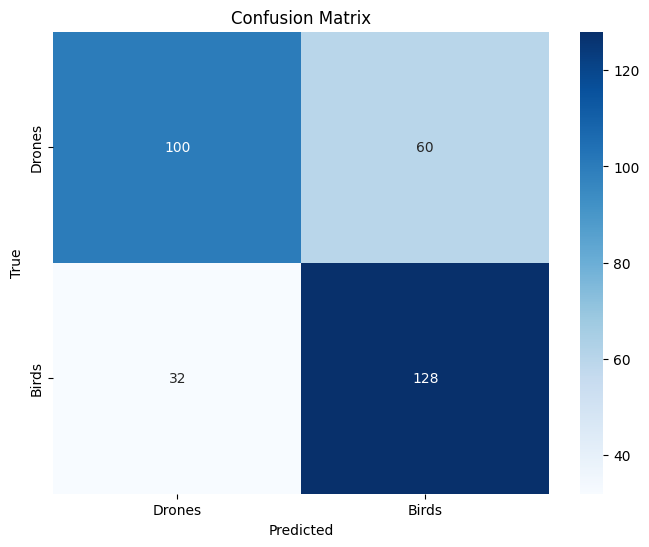

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('model10.h5')

# Load and preprocess the test dataset
test_dataset_path = '/kaggle/working/split_data/test'  # Replace with the path to your test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dataset_path,
    labels='inferred',
    label_mode='binary',  # Adjust based on your label mode
    batch_size=32,
    image_size=(28, 28)
)

# Define the class names
class_names = ['Drones', 'Birds']  # Adjust based on your classes

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Iterate through the test dataset to make predictions
for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    predicted_labels = model.predict(images)
    predictions.extend((predicted_labels > 0.5).astype(int).flatten())  # Adjust the threshold as needed

# Generate a classification report
report = classification_report(true_labels, predictions, target_names=class_names)
print("Classification Report:\n", report)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Save the confusion matrix plot to a file
plt.savefig('confusion_matrix_10.png')

plt.show()


1/1 [==============================] - 0s 69ms/step


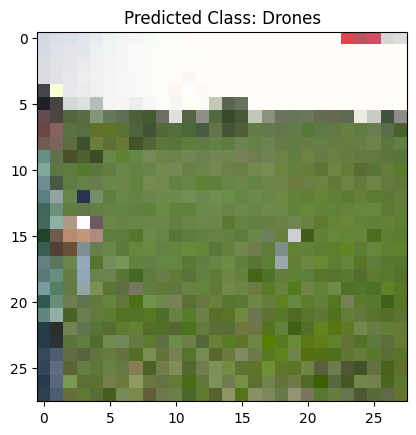

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('model10.h5')

# Load and preprocess the image you want to predict
# image_path ='/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Birds/singleBirdinsky124.jpeg'
# image_path = '/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Birds/singleBirdinsky102.jpeg'  # Replace with the path to your image
image_path = '/kaggle/input/birds-vs-drone-dataset/BirdVsDrone/Drones/100.JPEG'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(28, 28), color_mode='rgb')
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image to [0, 1]

# Make predictions on the preprocessed image
predictions = model.predict(x)
predicted_class = 'Drones' if predictions[0] > 0.5 else 'Birds'

# Visualize the image and predicted class
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()


# Filter Maps Visualization

In [ ]:
pip install keras-tuner

1/1 [==============================] - 1s 1s/step


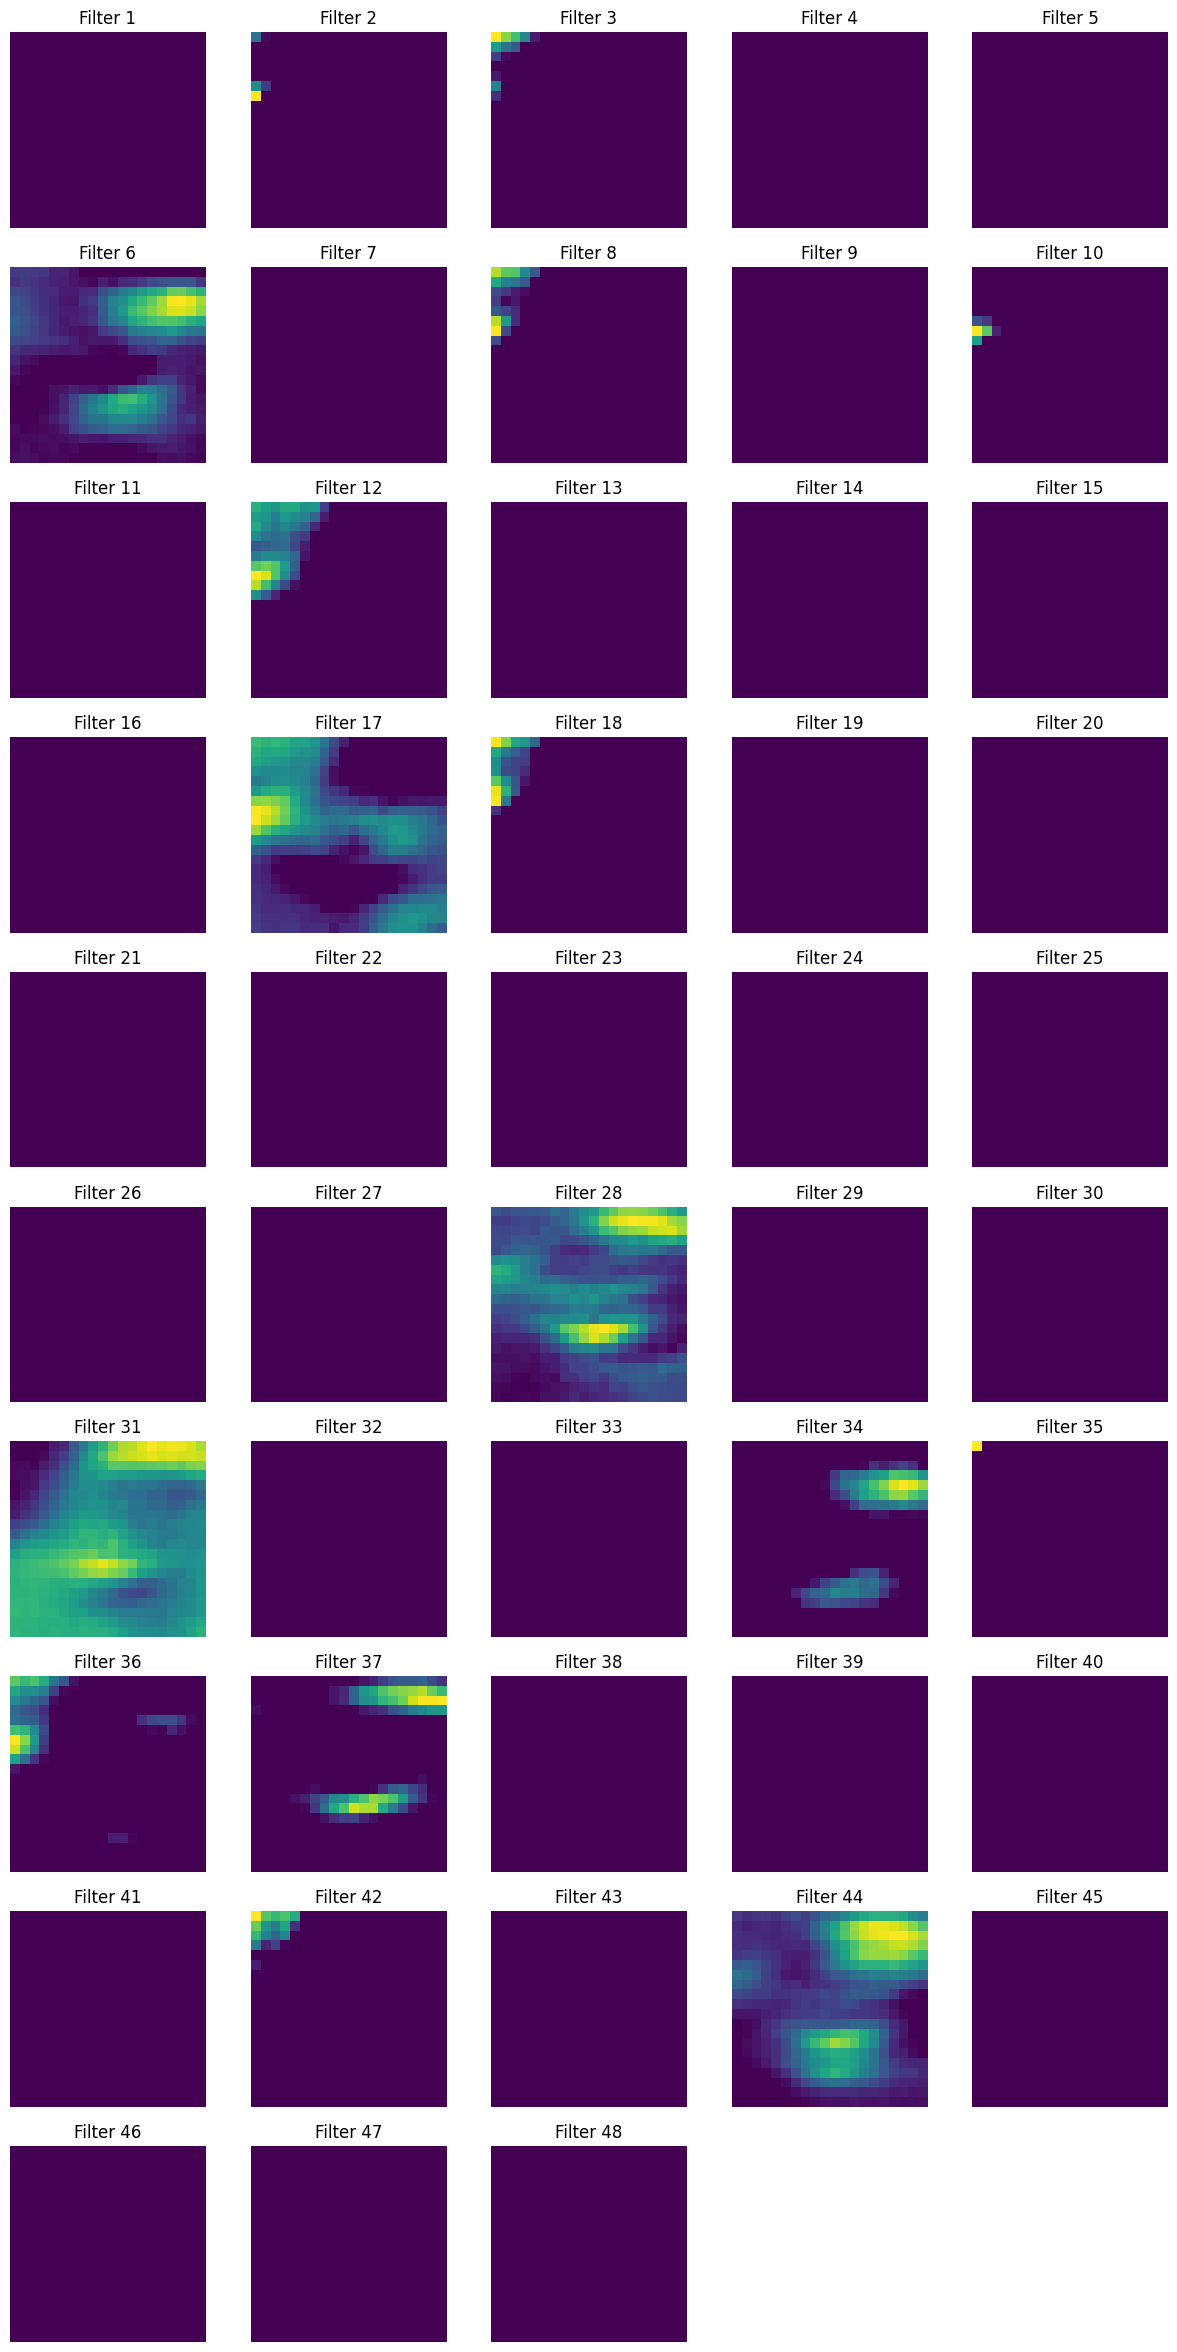

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('model10.h5')  # Replace with the path to your model

# Extract filter maps from a specific layer in the model
layer_name = 'conv2d_1'  # Replace with the actual layer name
filter_map_model = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

# Choose an input image from your dataset (you can replace this with an image from your dataset)
sample_image = train_images.take(1)  # Take one batch of images

# Generate filter maps
filter_maps = filter_map_model.predict(sample_image)

# Define the number of filters in the selected layer
num_filters = filter_maps.shape[-1]

# Set the number of filters to display in each row
filters_per_row = 5

# Calculate the number of rows required
num_rows = (num_filters - 1) // filters_per_row + 1

# Create subplots for filter maps
plt.figure(figsize=(15, 3 * num_rows))
for i in range(num_filters):
    plt.subplot(num_rows, filters_per_row, i + 1)
    plt.imshow(filter_maps[0, :, :, i], cmap='viridis')  # Adjust the index for the batch
    plt.axis('off')
    plt.title(f'Filter {i + 1}')

# Save the filter maps as an image
plt.savefig('filter_maps_010.png')

plt.show()
